# NVIDIA Blueprint: Retail Shopping Assistant

 This notebook will deploy the **Retail Shopping Assistant** AI Blueprint. You will install the necessary prerequisites, spin up the NVIDIA NIM™ microservices (either locally or using cloud endpoints), and deploy the multi-agent retail shopping system. Once deployed, you will have a fully functional reference UI as well as sample code which you can use to build intelligent retail shopping experiences with features like product search, cart management, visual search, and conversational AI interactions.

## Diagram
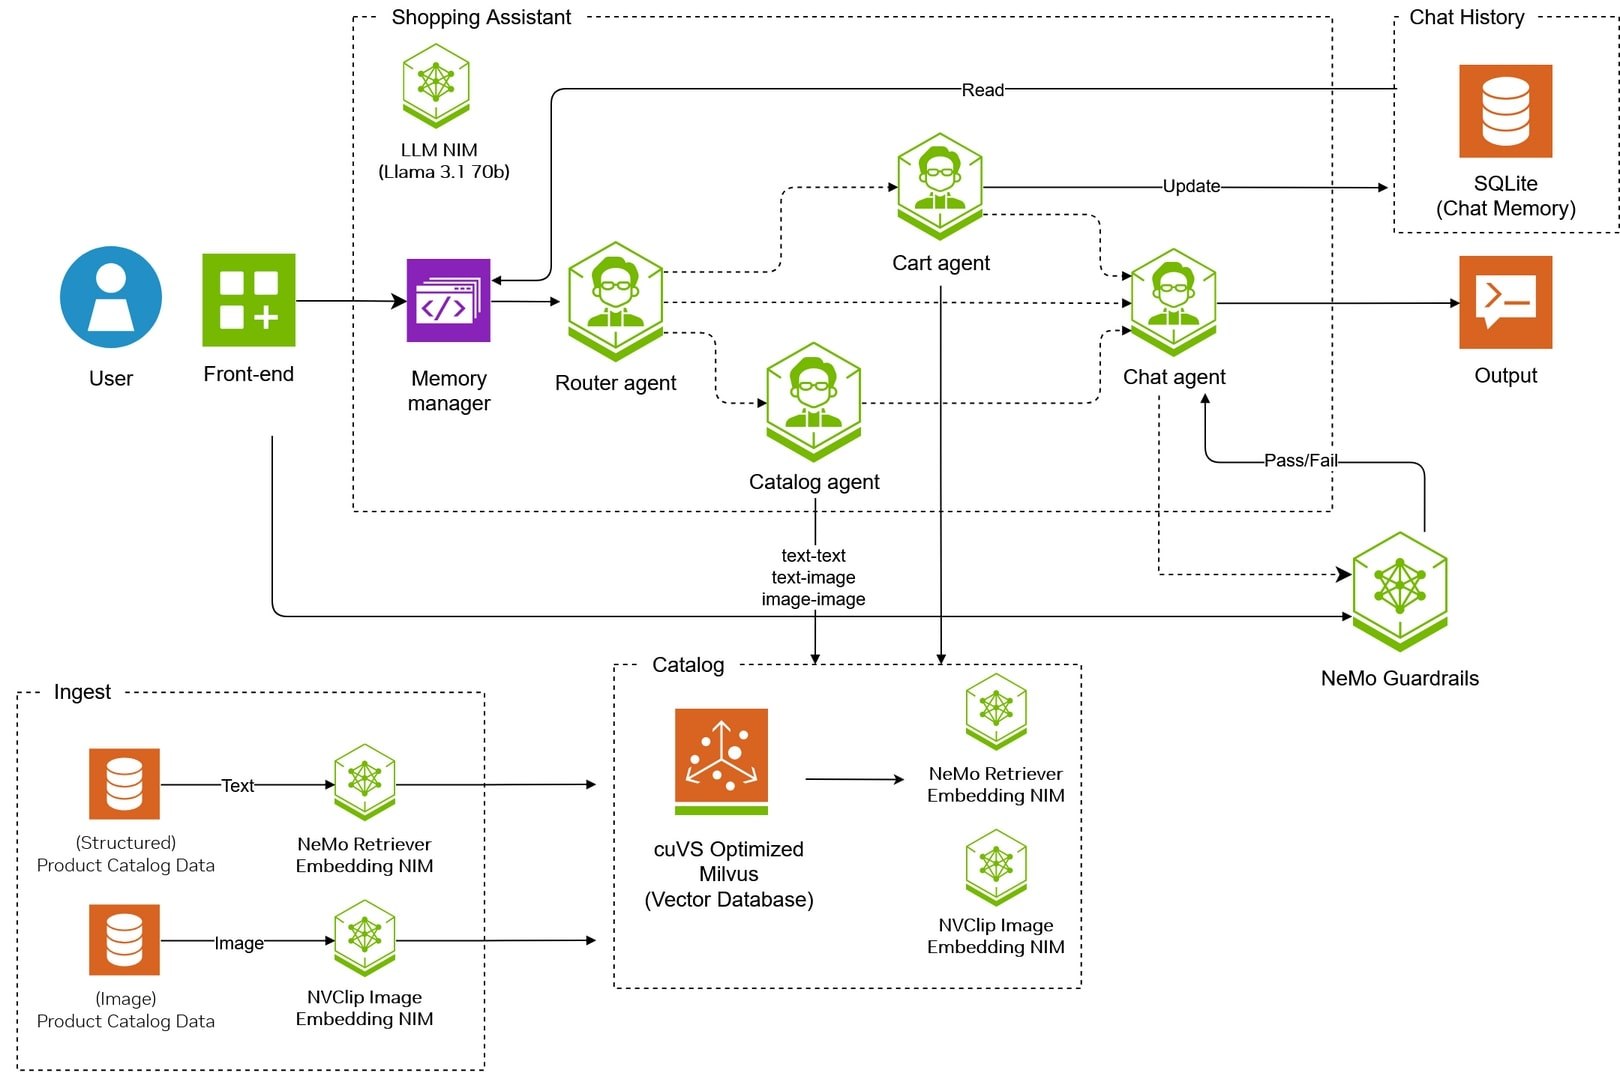

# Getting Started
>[Prerequisites](#Prerequisites)  
>[Environment Setup](#Environment-Setup)  
>[Configuration Options](#Configuration-Options)  
>[Deployment Options](#Deployment-Options)  
>[Local NIM Deployment](#Local-NIM-Deployment)  
>[Cloud NIM Deployment](#Cloud-NIM-Deployment)  
>[Application Deployment](#Application-Deployment)  
>[Validate Deployment](#Validate-Deployment)  
>[API Reference](#API-Reference)  
>[Next Steps](#Next-Steps)  
>[Shutting Down Blueprint](#Stopping-Services-and-Cleaning-Up)  
>[Appendix](#Appendix)  
________________________

## Prerequisites

### Clone repository and install software

1. **Clone** Retail Shopping Assistant Git repository

In [ ]:
!git clone https://github.com/NVIDIA-AI-Blueprints/retail-shopping-assistant.git #Using HTTP
!cd retail-shopping-assistant

2. Install **[Docker](https://docs.docker.com/engine/install/ubuntu/)**

<div class="alert alert-block alert-success">
    <b>Tip:</b> Ensure the Docker Compose plugin version is 2.29.1 or higher.  Run `docker compose version` to confirm. Refer to Install the Compose plugin Docker documentation for more information.
</div>

In [ ]:
!docker compose version

3. Install **[NVIDIA Container Toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html#installing-the-nvidia-container-toolkit)** to configure Docker for GPU-accelerated containers, for example Milvus, NVIDIA NIM.
 If you are using a system deployed with Brev you can skip this step since Brev systems come with NVIDIA Container Toolkit preinstalled.

<div class="alert alert-block alert-info">
    <b>Note:</b> After installing the toolkit, follow the instructions in the Configure Docker section in the NVIDIA Container Toolkit documentation.
</div>

### System Requirements

#### For Local NIM Deployment (Recommended)
- **GPUs**: 4x H100 GPUs (or equivalent)
- **RAM**: 128GB+ system memory
- **Storage**: 100GB+ available disk space
- **CPU**: 16+ cores

#### For Cloud NIM Deployment
- **RAM**: 32GB+ system memory
- **Storage**: 50GB+ available disk space
- **CPU**: 8+ cores
- **Network**: Stable internet connection

<div class="alert alert-block alert-info">
    <b>Note:</b> Use oauthtoken as the username and your API key as the password. The $oauthtoken username is a special name that indicates that you will authenticate with an API key and not a user name and password.
</div>

### Get API Keys

#### Let's set the NVIDIA API Catalog key.

This NVIDIA API Catalog key will be used to access cloud hosted models in API Catalog.

You can use different model API endpoints with the same API key.

1. Navigate to **[NVIDIA API Catalog](https://build.nvidia.com/explore/discover)**.

2. Select a model, such as llama3-8b-instruct.

3. Select an **Input** option. The following example is of a model that offers a Docker option. Not all of the models offer this option, but all include a "Get API Key" link

4. Click **Get API Key**.

5. Select **"Generate Key"**

6. **Copy your key** and store it in a secure place. Do not share it.

<div class="alert alert-block alert-success">
    <b>Tip:</b> The key begins with the letters nvapi-.
</div>

7. Input your key to the local environment using the following code block.

In [ ]:
import getpass
import os
if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvidia_api_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvidia_api_key.startswith("nvapi-"), f"{nvidia_api_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvidia_api_key

#### Let's log into the NVIDIA Container Registry.

The NVIDIA NGC API Key is a mandatory key that is required to use this blueprint. This is needed to log into the NVIDIA container registry, nvcr.io, and to pull secure container images used in this NVIDIA NIM Blueprint.
Refer to [Generating NGC API Keys](https://docs.nvidia.com/ngc/gpu-cloud/ngc-user-guide/index.html#generating-api-key) in the NVIDIA NGC User Guide for more information.

Authenticate with the NVIDIA Container Registry with the following commands:

In [ ]:
!docker login nvcr.io --username '$oauthtoken' --password $NVIDIA_API_KEY

## Environment Setup

Next we will set up the environment variables and create necessary directories. Here, each enfironment variable controls a different model container within the model. By default we set all of these to use our NVIDIA_API_KEY, but you can use different keys and different endpoints for your embedding model, LLM, and guardrails.

In [ ]:
# Set environment variables
os.environ["NGC_API_KEY"] = os.environ.get("NVIDIA_API_KEY", "")
os.environ["LLM_API_KEY"] = os.environ["NGC_API_KEY"]
os.environ["EMBED_API_KEY"] = os.environ["NGC_API_KEY"]
os.environ["RAIL_API_KEY"] = os.environ["NGC_API_KEY"]

# Create NIM cache directory
local_nim_cache = os.path.expanduser("~/.cache/nim")
os.environ["LOCAL_NIM_CACHE"] = local_nim_cache
os.makedirs(local_nim_cache, exist_ok=True)
os.system(f"chmod a+w {local_nim_cache}")

print(f"Environment variables set")
print(f"NIM cache directory: {local_nim_cache}")

## Configuration Options

The Retail Shopping Assistant supports a flexible configuration override system that allows you to switch between different deployment scenarios without modifying the base configuration files.

### How Configuration Override Works

1. **Base Configuration**: The application loads the base `config.yaml` file
2. **Override Detection**: If the `CONFIG_OVERRIDE` environment variable is set, the system looks for an override file
3. **Merge Process**: The override file values are merged into the base configuration, with override values taking precedence

### Available Configuration Options

| Configuration | Environment Variable | Description |
|---------------|---------------------|-------------|
| Local NIMs | `CONFIG_OVERRIDE=config-local.yaml` | Use locally deployed NIMs |
| Cloud NIMs | `CONFIG_OVERRIDE=config-build.yaml` | Use NVIDIA API Catalog hosted endpoints |
| Custom | `CONFIG_OVERRIDE=config-custom.yaml` | Use your own custom configuration |
| Default | (not set) | Use base configuration only |

## Deployment Options

The Retail Shopping Assistant supports two deployment options:

### Option 1: Local NIM Deployment (Recommended)
- **Best for**: Development, testing, production with GPU resources
- **Requirements**: 4x H100 GPUs, 128GB+ RAM
- **Pros**: Maximum performance, complete privacy, no ongoing cloud costs
- **Cons**: Higher hardware investment, more complex setup

### Option 2: Cloud NIM Deployment
- **Best for**: Development, testing, production without local GPUs
- **Requirements**: Stable internet connection
- **Pros**: No local GPU requirements, faster setup, pay-per-use
- **Cons**: Ongoing cloud costs, network latency, API rate limits

Choose your deployment option below:

## Local NIM Deployment

### Step 1: Set Configuration for Local NIMs

### 📋 Default Configuration

This deployment uses **local NIM models** by default, which means no overrides or configuration changes are needed for this option.

> **💡 Configuration Overrides:** Only needed if you want to:
> - Switch to remote model endpoints
> - Use custom build configurations  
> - Connect to different model services

### Step 2: Verify GPU Setup

In [ ]:
# Check NVIDIA drivers and GPU availability
!nvidia-smi

### Step 3: Deploy Local NIMs

This will start the following NVIDIA NIM microservices:
- **Llama 3.1 70B Instruct**: Large language model for conversation
- **NV-CLIP**: Visual understanding model for image search
- **NV-EmbedQA E5-v5**: Embedding model for semantic search
- **Llama 3.1 Nemoguard Content Safety**: Content moderation
- **Llama 3.1 Nemoguard Topic Control**: Topic control and safety

Note, we are going to hide the outputs in order to not flood the Notebook.

In [ ]:
# Start local NIMs
!cd retail-shopping-assistant && docker compose -f docker-compose-nim-local.yaml up -d > /dev/null 2>&1

<div class="alert alert-block alert-info">
    <b>Note:</b> This may take up to **15 minutes** to complete as it downloads and initializes the NIM models. Once this block terminates the below block will monitor our progress launching our NIMs. When you run it and it says that the NIMs are available. You are ready to move on!
</div>

In [ ]:
# Monitor NIM startup progress
!cd retail-shopping-assistant && docker compose -f docker-compose-nim-local.yaml logs --tail 10

### Step 4: Verify NIM Deployment

In [ ]:
# Check NIM container status
!cd retail-shopping-assistant && docker compose -f docker-compose-nim-local.yaml ps

This command should produce similar output in the following format:

```
CONTAINER ID   NAMES                                   STATUS
1dd42caad60e   retail-shopping-assistant-llama-1      Up 10 minutes
766acb5fb57c   retail-shopping-assistant-nvclip-1     Up 10 minutes
4c4d1136cd7a   retail-shopping-assistant-embedqa-1    Up 10 minutes
ff2f71eb9d75   retail-shopping-assistant-content-1    Up 10 minutes
fd70635efcac   retail-shopping-assistant-topic_control-1 Up 10 minutes
```

## Cloud NIM Deployment

<div class="alert alert-block alert-info">
    <b>Note:</b> Skip Step 1 Set Configuration for Cloud NIMs if you are deploying the NIMs locally. Continue with Application Deployment
</div>

### Step 1: Set Configuration for Cloud NIMs

In [ ]:
%%script echo "Skipping cloud NIM deployment, remove this line to use cloud NIMs"
# Set configuration override for cloud NIM deployment
os.environ["CONFIG_OVERRIDE"] = "config-build.yaml"
print(f"Configuration override set to: {os.environ['CONFIG_OVERRIDE']}")

If you don't have local GPU resources, you can use cloud-hosted NIM endpoints. The application will automatically use the NVIDIA API Catalog hosted endpoints when local NIMs are not available.

<div class="alert alert-block alert-info">
    <b>Note:</b> When using cloud NIM deployment, you don't need to start the local NIM containers. The application will use the NVIDIA API Catalog hosted endpoints.
</div>

## Application Deployment

Docker compose scripts are provided which spin up the microservices on a single node. This docker-compose yaml file will start the retail shopping assistant services as well as dependent microservices. We will once-again hide the outputs from this as to not flood the notebook with print statements!

<div class="alert alert-block alert-success">
    <b>Tip:</b> Refer to the docker-compose.yaml for complete details.
</div>

In [ ]:
# Build and start application services
!cd retail-shopping-assistant && docker compose -f docker-compose.yaml up -d --build > /dev/null 2>&1

<div class="alert alert-block alert-info">
    <b>Note:</b> Again, this can take up to 10 minutes, so sit tight. Once it is up we will check the logs in the following code blocks once it completes.
</div>

<div class="alert alert-block alert-success">
    <b>Tip:</b> If you would like to monitor progress, refer to https://docs.docker.com/reference/cli/docker/compose/logs/.
</div>

In [ ]:
# Monitor application startup
!cd retail-shopping-assistant && docker compose -f docker-compose.yaml logs --tail 10

To validate the deployment of the blueprint, execute the following command to ensure the containers are running.

In [ ]:
!cd retail-shopping-assistant && docker compose -f docker-compose.yaml ps

This command should produce similar output in the following format:

```
CONTAINER ID   NAMES                       STATUS
e6e1f6ebec3c   shopping-frontend           Up 3 hours
b6a1853c4e81   chain-server                Up 3 hours
91487a937be1   catalog-retriever           Up 3 hours
0112183489fe   memory-retriever            Up 3 hours
9970bb569dbd   rails                       Up 3 hours
4ea1a3267a17   milvus-standalone           Up 3 hours
c988dcdd67c3   milvus-minio                Up 3 hours (healthy)
3dc1c2262903   milvus-etcd                 Up 3 hours (healthy)
```

<div class="alert alert-block alert-info">
    <b>Note:</b> The NIM microservices are not listed since they are either running locally (if using local deployment) or using hosted endpoints (if using cloud deployment).
</div>

## Validate Deployment

The blueprint includes a reference UI and an AI assistant (developed using the LangGraph framework) that leverages sub-agents to handle retail shopping queries. Let's make sure the API endpoints and UI are up and running.

### 1. Test our server health.

In [ ]:
# Test the chain-server health
!curl -s http://localhost:8009/health | python3 -m json.tool

In [ ]:
# Test the retriever health
!curl -s http://localhost:8010/health | python3 -m json.tool

In [ ]:
# Test the memory server health
!curl -s http://localhost:8011/health | python3 -m json.tool

<div class="alert alert-block alert-info">
    <b>Note:</b> If an error occurs, wait briefly and then try again.
</div>

### 2. Access the Web UI

If you are deploying the solution on an NVIDIA Brev instance, return to the Brev documentation and resume from Step 14: Access the Web Interface.
- [Brev Guide](https://github.com/NVIDIA-AI-Blueprints/retail-shopping-assistant/blob/main/docs/BREV.md)


Open your browser and navigate to: `http://localhost:3000`

<div class="alert alert-block alert-info">
    <b>Note:</b> If you are using an environment deployed with Brev, make sure to expose port 3000 on your Brev console and use the HTTP URL created.
</div>

## API Reference

For detailed API references, please refer to the following locations in the Blueprint repository:

- **Chain Server API**: `retail-shopping-assistant/docs/API.md`
- **User Guide**: `retail-shopping-assistant/docs/USER_GUIDE.md`

## Next Steps

Now that your Retail Shopping Assistant is deployed, you can:

1. **Explore the UI**: Test the conversational interface, product search, and cart management features
2. **Customize the Application**: Modify the configuration files to adapt to your specific retail domain
3. **Add Your Data**: Replace the sample data with your own product catalog and user data
4. **Scale the Deployment**: Consider production deployment options for high availability
5. **Monitor Performance**: Use the built-in monitoring and analytics features

For detailed customization and development guides, see:
- [User Guide](https://github.com/NVIDIA-AI-Blueprints/retail-shopping-assistant/blob/main/docs/USER_GUIDE.md)
- [API Documentation](https://github.com/NVIDIA-AI-Blueprints/retail-shopping-assistant/blob/main/docs/API.md)
- [Deployment Guide](https://github.com/NVIDIA-AI-Blueprints/retail-shopping-assistant/blob/main/docs/DEPLOYMENT.md)

## Stopping Services and Cleaning Up

To shut down the microservices, run the following commands:

In [ ]:
# Stop application services
!cd retail-shopping-assistant && docker compose -f docker-compose.yaml down > /dev/null 2>&1

In [ ]:
# Stop local NIMs (if using local deployment)
!cd retail-shopping-assistant && docker compose -f docker-compose-nim-local.yaml down > /dev/null 2>&1

## Appendix

### Switching Between Configurations

To switch between different configurations without redeploying:

```bash
# Switch to local NIMs
export CONFIG_OVERRIDE=config-local.yaml
docker compose -f docker-compose.yaml restart

# Switch to cloud NIMs
export CONFIG_OVERRIDE=config-build.yaml
docker compose -f docker-compose.yaml restart

# Use base configuration (no override)
unset CONFIG_OVERRIDE
docker compose -f docker-compose.yaml restart
```

### Creating Custom Configuration Overrides

You can create your own override files for custom configurations:

1. **Create the override file** in the same directory as the base config:
   ```bash
   # For chain server
   cp chain_server/app/config.yaml chain_server/app/config-custom.yaml
   
   # For catalog retriever
   cp catalog_retriever/src/config.yaml catalog_retriever/src/config-custom.yaml
   ```

2. **Modify the override file** with your custom values:
   ```yaml
   # Example: Custom LLM endpoint
   llm_port: "https://your-custom-endpoint.com/v1"
   llm_name: "your-custom-model"
   
   # Example: Custom embedding endpoint
   text_embed_port: "https://your-embedding-service.com/v1"
   text_model_name: "your-embedding-model"
   ```

3. **Use the custom override**:
   ```bash
   export CONFIG_OVERRIDE=config-custom.yaml
   docker compose -f docker-compose.yaml up -d --build
   ```

### Troubleshooting Common Issues

#### GPU Memory Issues
If you encounter GPU memory issues with local NIM deployment:

```bash
# Check GPU memory usage
nvidia-smi

# Adjust GPU allocation in docker-compose-nim-local.yaml
# Modify the device_ids for each service
```

#### Port Conflicts
If ports are already in use:

```bash
# Check what's using the ports
sudo netstat -tulpn | grep :8000
sudo netstat -tulpn | grep :3000

# Stop conflicting services or modify ports in docker-compose.yaml
```

#### NIM Startup Issues
If NIMs fail to start:

```bash
# Check NIM logs
docker compose -f docker-compose-nim-local.yaml logs -f

# Verify NGC API key
echo $NGC_API_KEY

# Check disk space
df -h
```

#### Configuration Override Issues
If configuration overrides are not working:

```bash
# Check if override file exists
ls -la chain_server/app/config-*.yaml
ls -la catalog_retriever/src/config-*.yaml

# Verify environment variable is set
echo $CONFIG_OVERRIDE

# Check application logs for config loading messages
docker compose -f docker-compose.yaml logs chain-server | grep -i config
```

### Performance Optimization

#### GPU Allocation
By default, GPU IDs are allocated as follows:
- **GPUs 0-1**: Llama 3.1 70B Instruct (LLM)
- **GPU 2**: NV-CLIP (Visual), NV-EmbedQA (Embeddings), Content Safety
- **GPU 3**: Topic Control

To change GPU allocation, modify the `device_ids` in `docker-compose-nim-local.yaml`:

```yaml
deploy:
  resources:
    reservations:
      devices:
        - driver: nvidia
          device_ids: ['0', '1']  # Change these IDs
          capabilities: [gpu]
```

#### Memory Optimization
For systems with limited RAM:

```yaml
# Add memory limits to docker-compose.yaml
services:
  chain-server:
    deploy:
      resources:
        limits:
          memory: 8G
```

### Production Deployment Considerations

For production deployments, consider:

1. **Load Balancing**: Use a reverse proxy (nginx, traefik) for high availability
2. **Monitoring**: Implement Prometheus/Grafana for metrics and alerting
3. **Logging**: Centralized logging with ELK stack or similar
4. **Security**: Implement proper authentication and authorization
5. **Backup**: Regular backups of Milvus and PostgreSQL data
6. **Scaling**: Horizontal scaling with Kubernetes for high traffic

See the [Deployment Guide](https://github.com/NVIDIA-AI-Blueprints/retail-shopping-assistant/blob/main/docs/DEPLOYMENT.md) for detailed production setup instructions.